* Reference: __Modelling and trading the gasoline crack spread: A non-linear story__ *by* Christian L. Dunis, Jason Laws and Ben Evans

# Introduction

This notebook follows the works of Dunis et al. in the exploration of various Machine Learning models, with application to fundamental commodity-based spreads. 

A fair value model is developed based on the works of (Enders and Granger 1998). This is used as a benchmark for other non-linear models such as multi-layer perceptron  (MLP), recurrent neural networks (RNN) and higher-order neural networks (HONN). The models are used to forecast $\Delta S_t$, the daily change in the spread. 

Finally, the unfiltered spread is benchmarked against a correlation filter, a time-varying leverage-based volatility filter and, the more traditional threshold filter and, if the cointegration exhibits asymmetry, an asymmetric threshold filter.

# Outline

- Spreads 
    - Crack - (Gasoline - WTI) (RB - CL)
    - ~~Crush - (Soybeans - Soyoil) (ZS - ZL)~~
    - ~~Spark - (Gulf Coast LNG Export Futures - ERCOT SOUTH 345 KV HUB) (LNG - YUEF1)~~
    - ~~Frac - (Natural Gas - Heating Oil) (LNG - H0)~~

- Rollover Method
    - By Same Expiration Date

- Ensemble
    - RegressorCommittee

- Models
    - Fair value model
        - Johansen Portfolio
        - [TAR Model](#tar) 
    - [Multi Layer Perceptron](#mlp) 
    - [Long Short Term Memory Network](#rnn)
    - Higher-Order Neural Network
        - Single Layer
            - [Feature Expander](#flnn)
        - Multi layer
            - [Pi Sigma Neural Network](#pisigma)

- Filters
    - Unfiltered
    - Threshold
    - Correlation
    - Volatility

In [4]:
from IPython.display import Image

import random
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

from arbitragelab.cointegration_approach.johansen import JohansenPortfolio
from arbitragelab.ml_approach.regressor_committee import RegressorCommittee
from arbitragelab.util.spread_modeling_helper import SpreadModelingHelper
from arbitragelab.ml_approach.neural_networks import (MultiLayerPerceptron, RecurrentNeuralNetwork,
                                                      PiSigmaNeuralNetwork)

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Seed value
seed_value = 0

# Set the built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Working with Future Contracts

In this notebook, the spread being modelled is the difference between the Crude oil Future contract and the RBOB Gasoline Future contract. 

The size of the Crude oil future is 1,000 barrels, and the size of the RBOB gasoline future is 42,000 gallons. 

Futures prices need to be handled in a special way, because of their tendency to expire in either of two states; contango or backwardation. This leads to gaps in the price series, that makes it unusable for backtesting purposes. 

The processing of these prices is done through the technique called futures rolling. It involves calculating the gap between the day before expiration and the corresponding day of the new contract, and cumulatively summing these gaps in the direction of the user's choice.

Also, note the resulting series from the rolling procedure will be in absolute terms (price differences) instead of relative terms (percentage difference).

### __Below is an example of the accumulated differences between a rolled and unrolled crude oil contract__

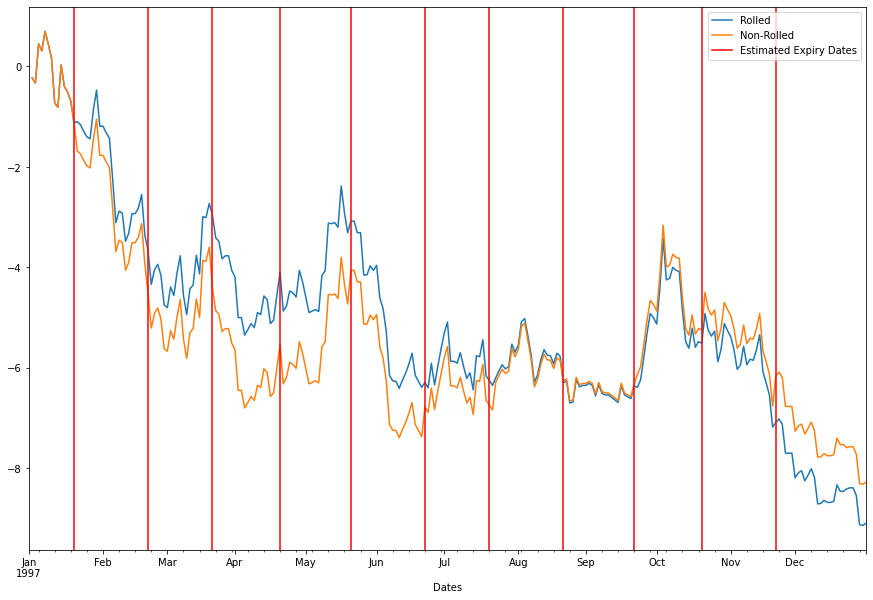

In [8]:
# Load unrolled futures data.
cl_df = pd.read_csv('./data/CL.csv', index_col='Dates', parse_dates=True)
cl_df.dropna(inplace=True)

# Load rolled futures data.
cl_forward_df = pd.read_csv('./data/CL_rolled_forward.csv', index_col='Dates', parse_dates=True)
cl_forward_df.dropna(inplace=True)

# Plot year of differences for intuition.
cl_forward_df['PX_LAST']['1997-01': '1997-12'].diff().cumsum().plot(figsize=(15,10))
cl_df['PX_LAST']['1997-01': '1997-12'].diff().cumsum().plot(figsize=(15,10))

for month in range(1, 12):
    plt.axvline(pd.datetime(1997, month, 21), color='r')

plt.legend(["Rolled", "Non-Rolled", "Estimated Expiry Dates"]);

Now in this notebook, the expiration dates of the contracts are different. This is amended using the methodology described in (Dunis et al. 2006) which entails using the same expiration date for both contracts.

At the same time, the RBOB contract exhibited price negativity after the rolling procedure. In general, we want to use non-negative series, thus a postprocessing method described in (De Prado 2018) was used to convert both contracts to non negative series.

## Rolling Implementation Details: 

Link to [Notebook](futures_rollover.ipynb)

In [10]:
# Load Non Negative Prices.
wti_contract_df = pd.read_csv('./data/NonNegative_CL_forward_roll.csv', index_col='Dates', parse_dates=True)
rbob_contract_df = pd.read_csv('./data/NonNegative_nRB_forward_roll.csv', index_col='Dates', parse_dates=True)

# Concatenate both price series.
working_df = pd.concat([wti_contract_df, rbob_contract_df], axis=1)
working_df.columns = ['wti', 'gasoline']

working_df.dropna(inplace=True)
working_df

,wti,gasoline
Dates,,
2006-01-03,1.034404,1.026552
2006-01-04,1.038991,1.048563
2006-01-05,1.028670,1.044253
2006-01-06,1.051933,1.060632
2006-01-09,1.040301,1.033046
...,...,...
2019-12-25,0.431366,1.056159
2019-12-26,0.435390,1.072488
2019-12-27,0.435672,1.068574


In [11]:
# Using arbitragelab implementation to setup the spread based on the Johansen cointegration method.
johansen_portfolio = JohansenPortfolio()
johansen_portfolio.fit(working_df)
sprd = johansen_portfolio.construct_mean_reverting_portfolio(working_df).diff()

# Threshold Auto Regressive Model  <a class="anchor" id="tar"></a>

Link to [Notebook](fair_value_modeling.ipynb)


# Multi Layer Perceptron  <a class="anchor" id="mlp"></a>

The MLP network has three layers; they are the input layer (explanatory variables), the output layer (the model estimation of the time series) and the hidden layer. The number of nodes in the hidden layer defines the amount of complexity that the model can fit.

0.4162161137425784


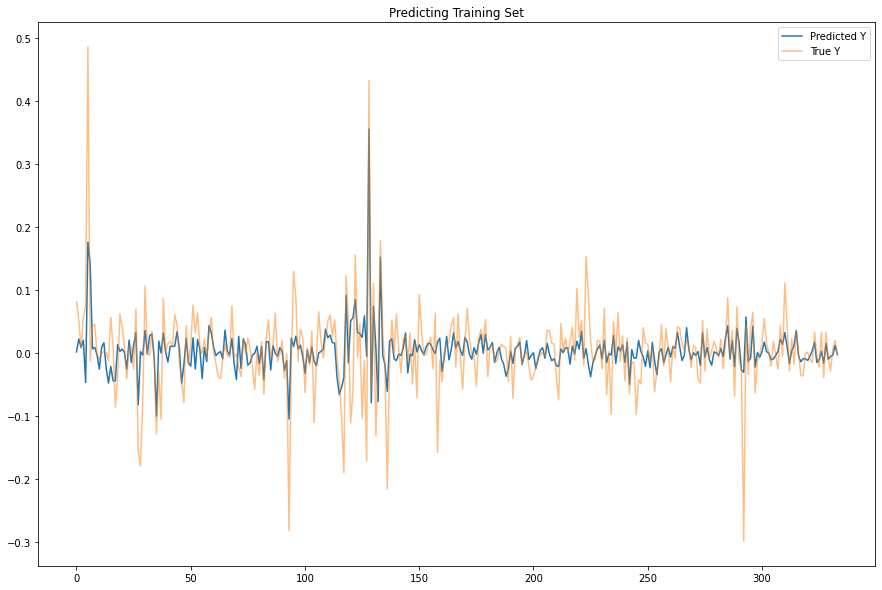

0.2922186808326058


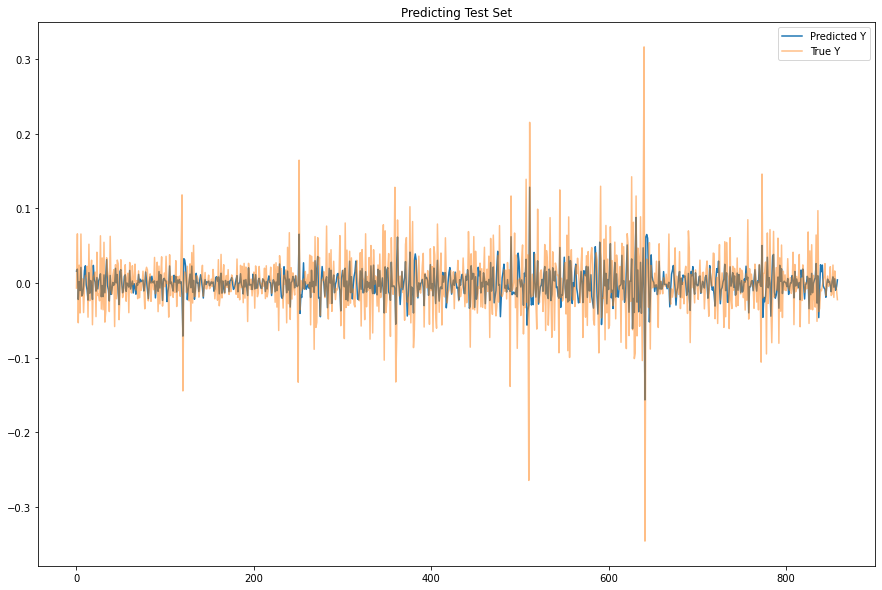

0.336632374564488


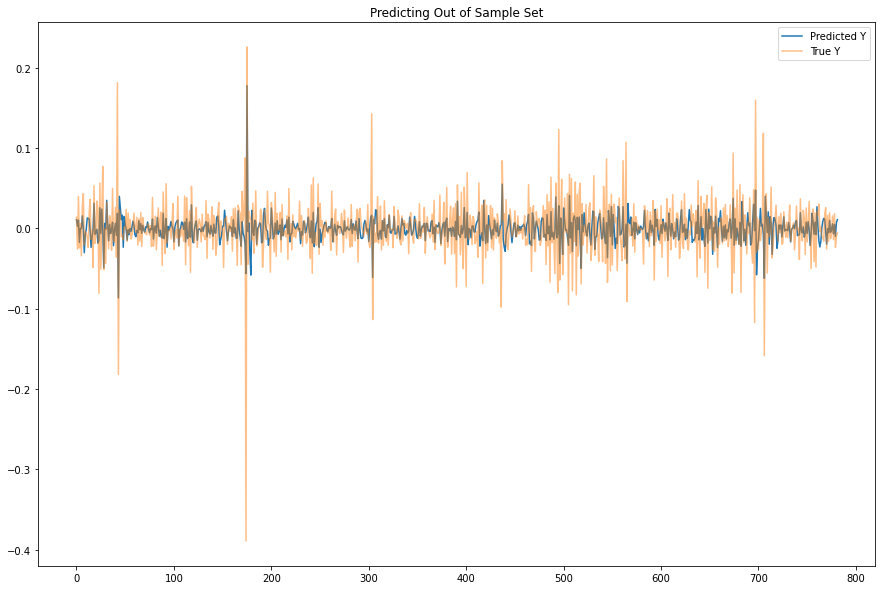

In [16]:
# Initializing the Helper Class with the linear fair value spread as input
# with unique sampling enabled.
helper = SpreadModelingHelper(sprd, feat_expansion=False, unique_sampling=True)

_, frame_size = helper.input_train.shape

# Here the parameters for a standard Regressor Neural Network are set.
mlp_params = {'frame_size': frame_size, 'hidden_size': 8, 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "sigmoid",
                    'output_layer_act_func': "linear"}

# The RegressorCommittee is initialized with the sample network parameters using the 
# MLP class and a committee of size 10.
committee = RegressorCommittee(mlp_params, regressor_class='MultiLayerPerceptron',
                               num_committee=10, epochs=500, verbose=False)
committee.fit(helper.input_train, helper.target_train)

# Plot predicted values vs actual values.
train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [28]:
# Show performance metrics for the various dataset partitions.
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Annual Volatility,Max Drawdown,Sharpe Ratio,Set
0,unfiltered,-7.55,25.69,-77.24,0.00,train
1,std_threshold,3.36,31.15,-28.54,0.13,train
2,corr_filter,-1.61,19.32,-18.62,-0.14,train
3,std_vol_filter,41.54,31.44,-7.17,0.46,train
4,corr_vol_filter,-5.29,24.50,-28.49,-0.31,train
0,unfiltered,-46.73,20.93,-97.46,-0.03,test
1,std_threshold,3.19,17.29,-1.62,0.56,test
2,corr_filter,17.41,25.69,-29.38,0.16,test
3,std_vol_filter,1.85,17.36,-3.25,0.34,test
4,corr_vol_filter,31.83,38.03,-24.22,0.16,test


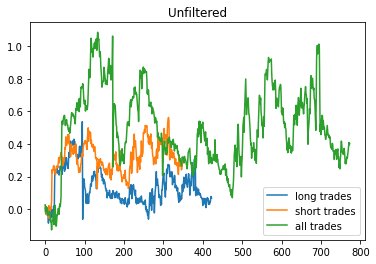

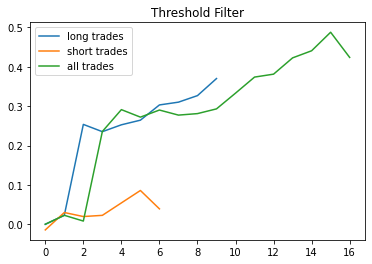

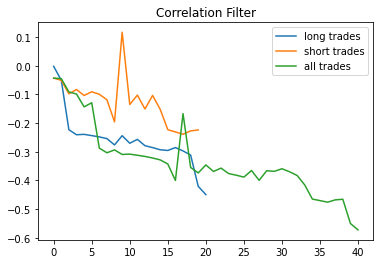

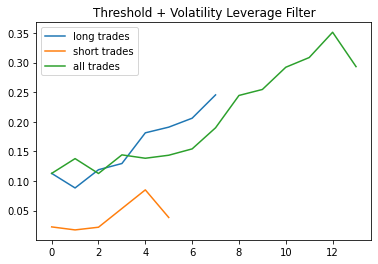

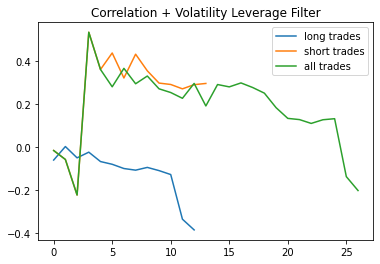

In [29]:
# Plot cumulative returns of the out of sample dataset partition.
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# Functional Link Neural Network <a class="anchor" id="flnn"></a>

Functional Link NN use joint activation functions; this technique reduces the need to establish the relationships between inputs when training. Furthermore, this reduces the number of free weights and means that network can be faster to train than even MLPs. Because the number of inputs can be very large for higher-order architectures,
however, orders of 4 and over are rarely used. Another advantage of reducing free weights is that the problems of overfitting and local optima affecting the results can be largely avoided.

0.33669189723777593


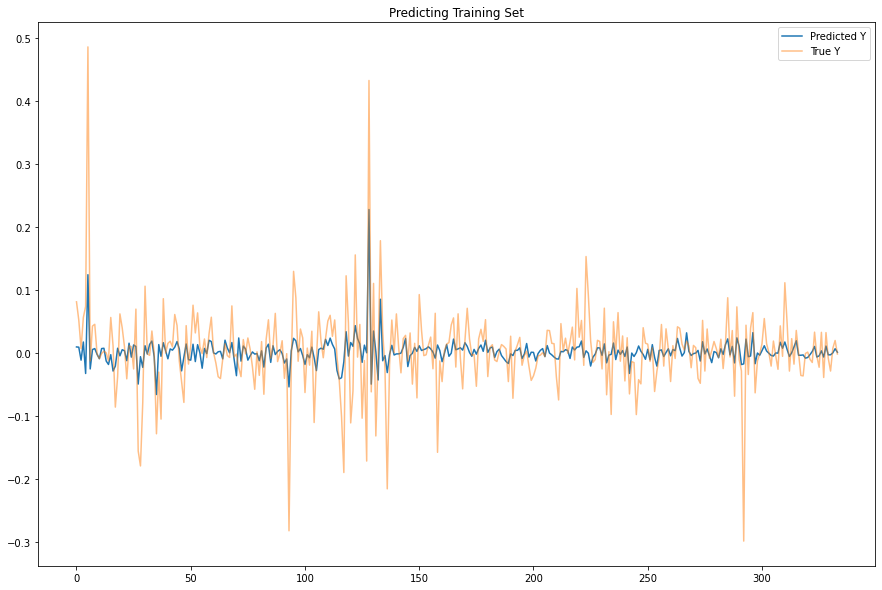

0.2281474411776978


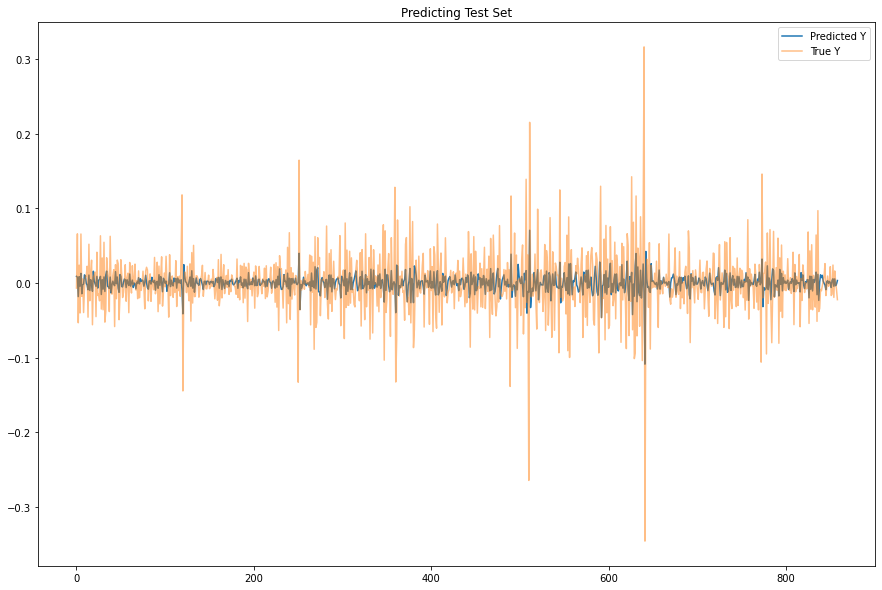

0.2577594357912787


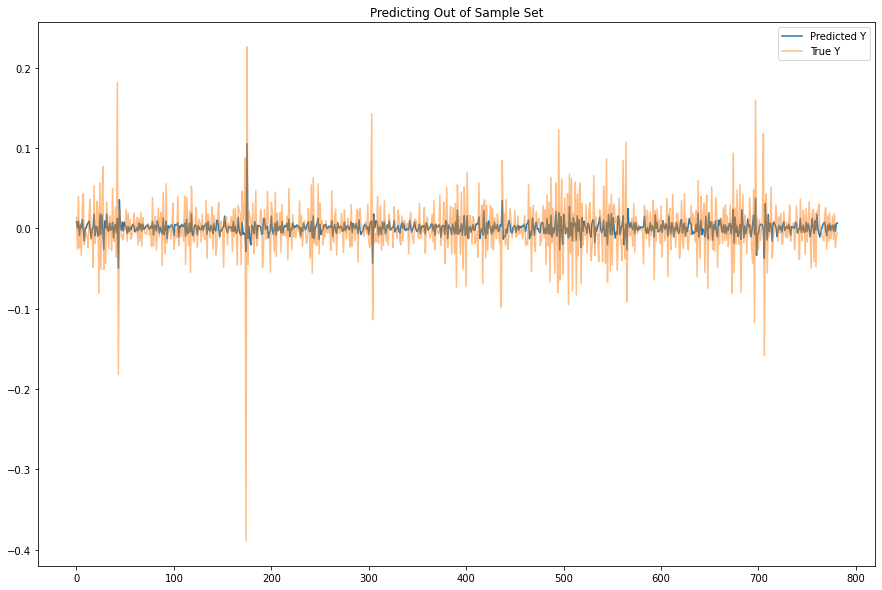

In [30]:
# Initializing the Helper Class with the linear fair value spread as input
# with both unique sampling and feature expansion enabled.
helper = SpreadModelingHelper(sprd, feat_expansion=True, unique_sampling=True)

_, frame_size = helper.input_train.shape

# Here the parameters for a standard Regressor Neural Network are set.
honn_params = {'frame_size': frame_size, 'hidden_size': 2, 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "relu",
                    'output_layer_act_func': "linear"}

# The RegressorCommittee is initialized with the sample network parameters using the 
# MLP class and a committee of size 10.
committee = RegressorCommittee(honn_params, regressor_class='MultiLayerPerceptron',
                               num_committee=10, epochs=500, verbose=False)
committee.fit(helper.input_train, helper.target_train)

# Plot predicted values vs actual values.
train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [31]:
# Show performance metrics for the various dataset partitions.
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Annual Volatility,Max Drawdown,Sharpe Ratio,Set
0,unfiltered,-19.10,25.76,-90.94,-0.04,train
1,std_threshold,-1.23,31.78,-29.53,0.01,train
2,corr_filter,-1.61,19.32,-18.62,-0.14,train
3,std_vol_filter,8.15,35.53,-20.25,0.14,train
4,corr_vol_filter,-4.89,24.24,-26.86,-0.29,train
0,unfiltered,-61.02,20.89,-98.81,-0.06,test
1,std_threshold,1.06,20.04,-4.78,0.11,test
2,corr_filter,17.41,25.69,-29.38,0.16,test
3,std_vol_filter,-1.34,25.79,-11.76,-0.04,test
4,corr_vol_filter,35.11,38.23,-24.00,0.17,test


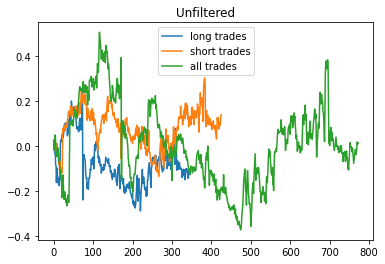

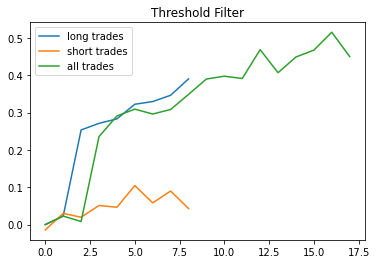

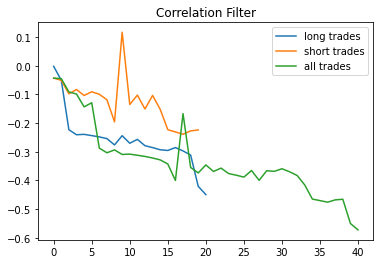

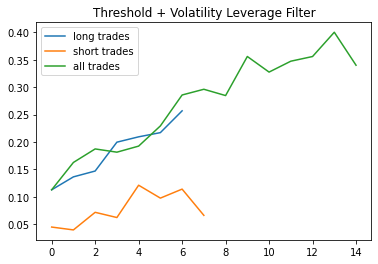

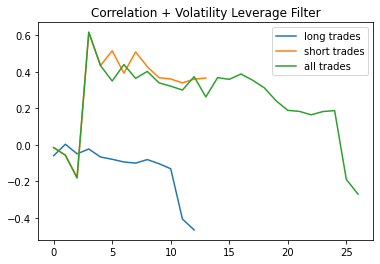

In [32]:
# Plot cumulative returns of the out of sample dataset partition.
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# Pi Sigma Neural Network <a class="anchor" id="pisigma"></a>
Pi Sigma network can be considered as a class of feedforward fully connected HONNs. First introduced by (Shin and Ghosh 1991), the Pi Sigma network utilizes product cells as the output units to indirectly incorporate the capabilities of higher-order networks while using a fewer number of weights and processing units. Their creation
was motivated by the need to create a network combining the fast learning property of single-layer networks with the powerful mapping capability of HONNs while avoiding the combinatorial increase in the required number of weights. While the order of the more traditional HONN architectures is expressed by the complexity of the inputs, in the context of Pi Sigma, it is represented by the number of hidden nodes.

-0.05187915665514753


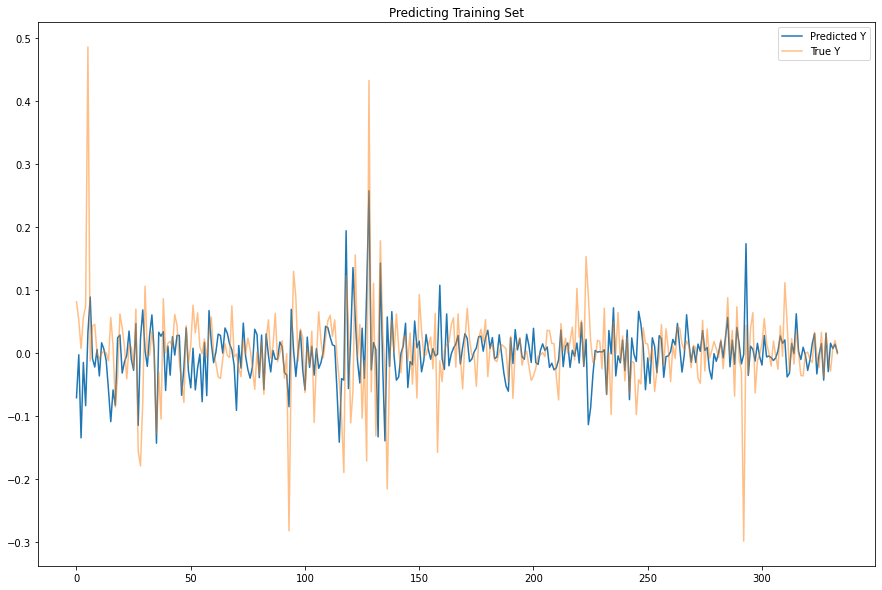

-0.18076073066744658


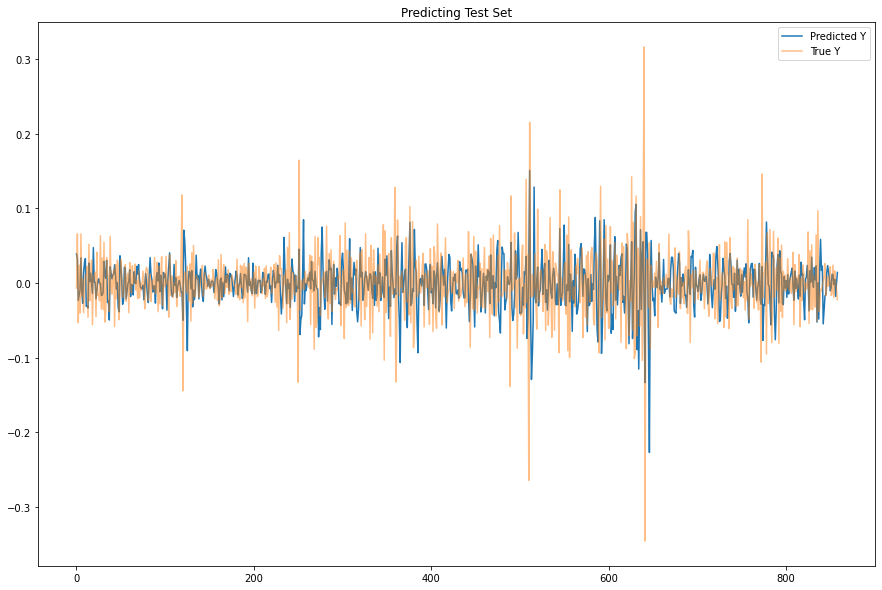

-0.10935096360439567


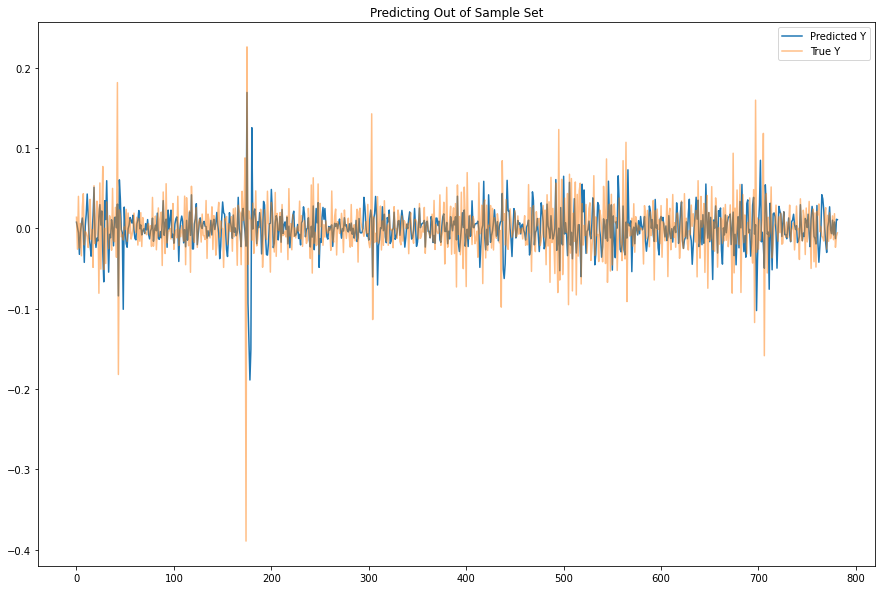

In [33]:
# Initializing the Helper Class with the linear fair value spread as input
# with unique sampling enabled.
helper = SpreadModelingHelper(sprd, feat_expansion=False, unique_sampling=True)

_, frame_size = helper.input_train.shape

# Here the parameters for the PiSigma Neural Network are set.
ps_params = {'frame_size': frame_size, 'hidden_size': 6, 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
             'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "linear",
             'output_layer_act_func': "tanh"}

# Here the committee class is initialized with PiSigmaNeuralNetwork as the member class
# and a committee size of 10.
committee = RegressorCommittee(ps_params, regressor_class='PiSigmaNeuralNetwork',
                               num_committee=10, epochs=500, verbose=False)
committee.fit(helper.input_train, helper.target_train)

# Plot predicted values vs actual values.
train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [34]:
# Show performance metrics for the various dataset partitions.
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Annual Volatility,Max Drawdown,Sharpe Ratio,Set
0,unfiltered,-20.25,25.64,-92.58,-0.05,train
1,std_threshold,-14.50,38.29,-70.70,-0.34,train
2,corr_filter,-1.61,19.32,-18.62,-0.14,train
3,std_vol_filter,-33.46,50.50,-79.48,-0.42,train
4,corr_vol_filter,-3.36,21.66,-21.37,-0.25,train
0,unfiltered,-67.60,20.87,-98.87,-0.08,test
1,std_threshold,-9.67,22.95,-22.55,-0.26,test
2,corr_filter,17.41,25.69,-29.38,0.16,test
3,std_vol_filter,-14.39,27.29,-32.40,-0.27,test
4,corr_vol_filter,18.52,32.69,-34.73,0.14,test


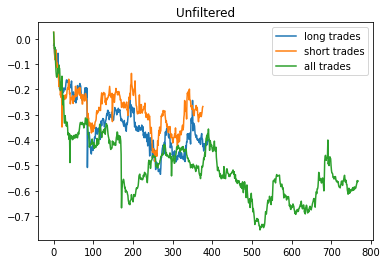

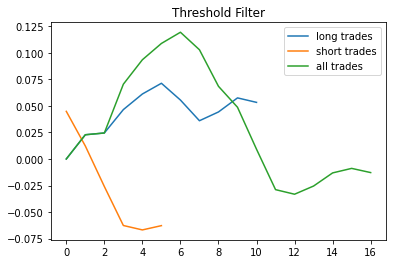

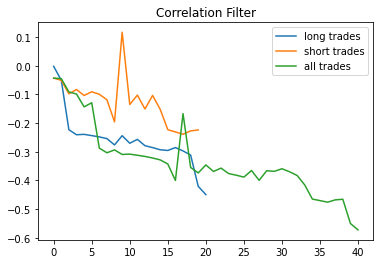

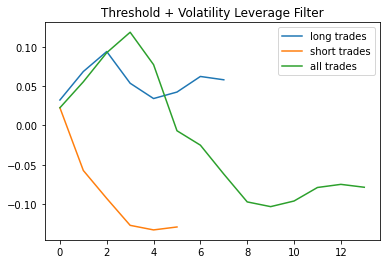

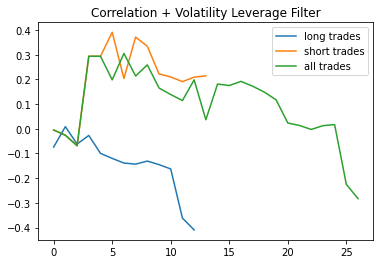

In [35]:
# Plot cumulative returns of the out of sample dataset partition.
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# Recurrent Neural Network <a class="anchor" id="rnn"></a>

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. The main driving factors for the development of LSTM's were to overcome two major technical problems in the classical SimpleRNN. The two technical problems are vanishing gradients and exploding gradients, both related to how the network is trained.

An LSTM layer consists of a set of recurrently connected blocks, known as memory blocks. Each one contains one or more recurrently connected memory cells and three multiplicative units – the input, output and forget gates – that provide continuous analogues of write, read and reset operations for the cells.

0.5344761076117932


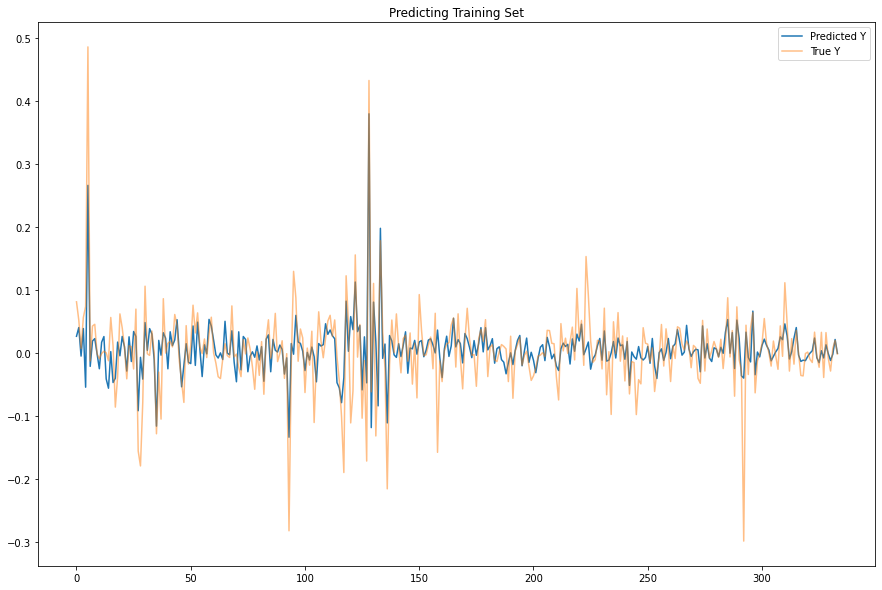

0.3826258883750908


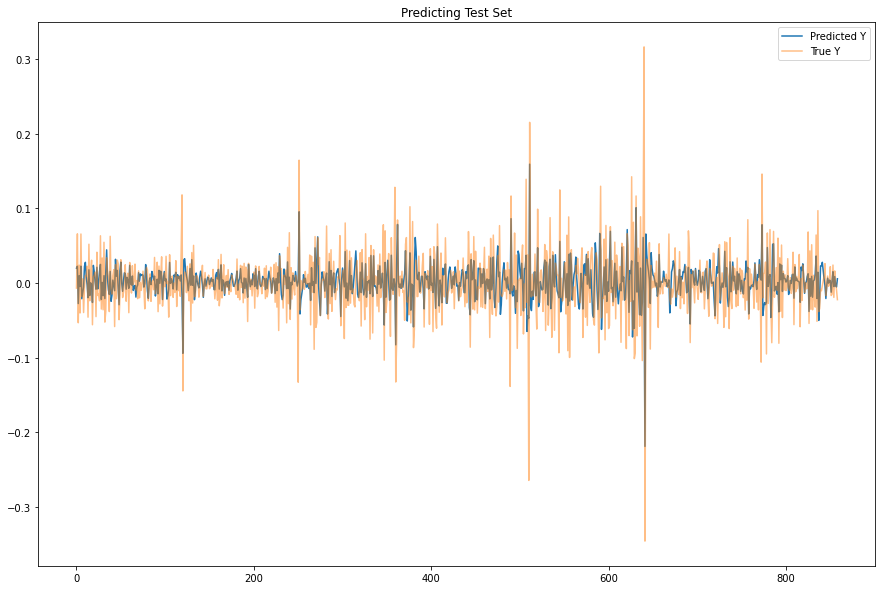

0.427756946894602


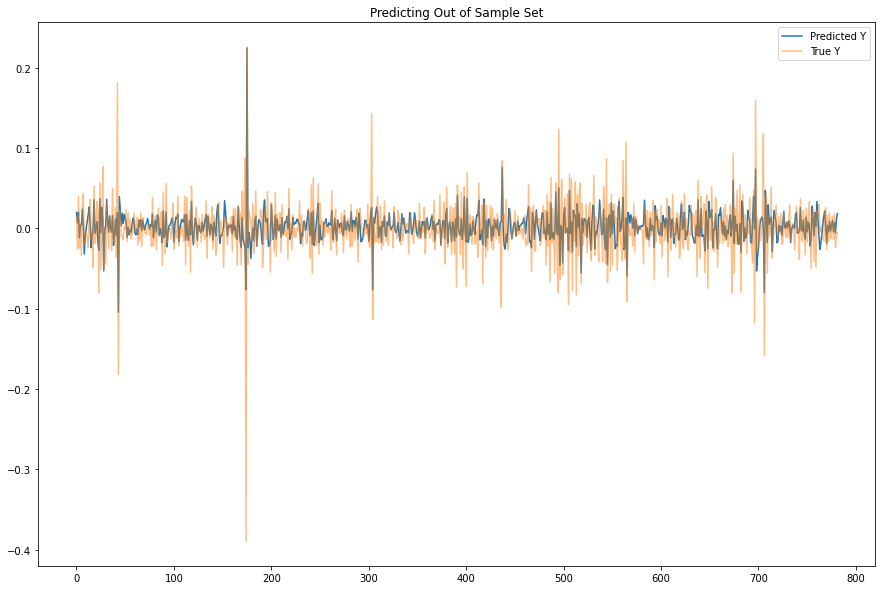

In [36]:
# Initializing the Helper Class with the linear fair value spread as input
# with unique sampling enabled.
helper = SpreadModelingHelper(sprd, feat_expansion=False, unique_sampling=True)

# The training variables are reshaped into [Samples, Time Steps, Features]
X_rnn_train = helper.input_train.reshape((helper.input_train.shape[0], helper.input_train.shape[1], 1))
X_rnn_test = helper.input_test.reshape((helper.input_test.shape[0], helper.input_test.shape[1], 1))
X_rnn_oos = helper.input_oos.reshape((helper.input_oos.shape[0], helper.input_oos.shape[1], 1))

_, frame_size, no_features = X_rnn_train.shape

# Here the parameters for the Recurrent Neural Network are set.
rnn_params = {'input_shape': (frame_size, no_features), 'num_outputs': 1, 'loss_fn': "mean_squared_error", 
                    'optmz': "adam", 'metrics': [], 'hidden_layer_activation_function': "relu",
                    'output_layer_act_func': "linear"}

committee = RegressorCommittee(rnn_params, regressor_class='RecurrentNeuralNetwork',
                               num_committee=10, epochs=500, verbose=False)
committee.fit(X_rnn_train, helper.target_train)

helper.input_train = X_rnn_train
helper.input_test = X_rnn_test
helper.input_oos = X_rnn_oos

# Plot predicted values vs actual values.
train_set, train_pred, test_set, test_pred, oos_set, oos_pred = helper.plot_model_results(committee)

In [37]:
# Show performance metrics for the various dataset partitions.
helper.get_metrics(working_df)

,Filtering Method,Annual Returns,Annual Volatility,Max Drawdown,Sharpe Ratio,Set
0,unfiltered,10.27,25.61,-58.14,0.07,train
1,std_threshold,4.10,31.00,-25.34,0.15,train
2,corr_filter,-1.61,19.32,-18.62,-0.14,train
3,std_vol_filter,56.18,37.27,-9.56,0.42,train
4,corr_vol_filter,-3.06,21.91,-22.44,-0.22,train
0,unfiltered,-60.13,20.90,-98.20,-0.06,test
1,std_threshold,1.44,17.25,-7.71,0.17,test
2,corr_filter,17.41,25.69,-29.38,0.16,test
3,std_vol_filter,-2.18,20.01,-11.56,-0.12,test
4,corr_vol_filter,31.61,38.16,-24.00,0.16,test


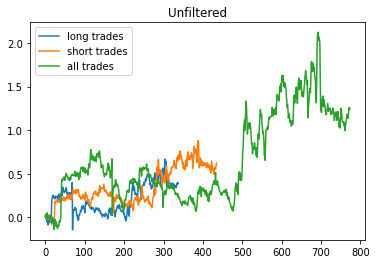

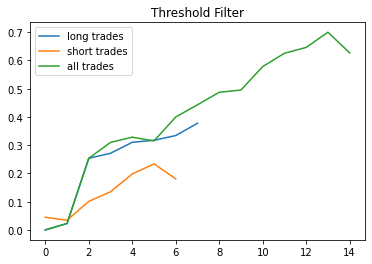

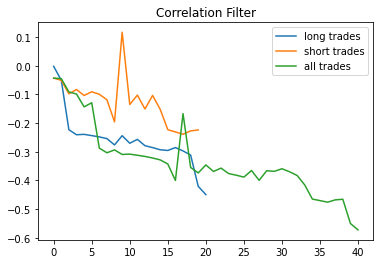

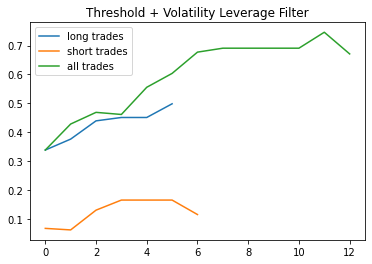

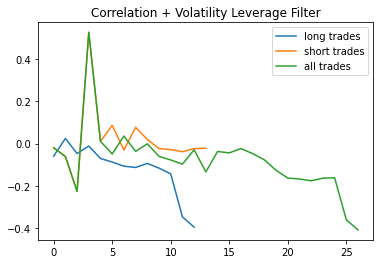

In [38]:
# Plot cumulative returns of the out of sample dataset partition.
helper.get_filtering_results(oos_set, oos_pred, test_pred, working_df);

# References

* Dunis, C.L., Laws, J. and Evans, B., 2006. Modelling and trading the gasoline crack spread: A non-linear story. Derivatives Use, Trading & Regulation, 12(1-2), pp.126-145.
* De Prado, M.L., 2018. Advances in financial machine learning. John Wiley & Sons.
* Shin, Y. and Ghosh, J. (1991) ‘The Pi-Sigma Network: An Efficient Higher-Order Neural Network for Pattern Classification and Function Approximation’, Proceedings IJCNN, Seattle, July, 13-18.
* Enders, W. and Granger, C.W.J., 1998. Unit-root tests and asymmetric adjustment with an example using the term structure of interest rates. Journal of Business & Economic Statistics, 16(3), pp.304-311.